In [ ]:
%run C:\Users\Omar\Desktop\Omar_Files\Python_Analysis\Siteck_ML\Pepper_Price_Analysis\notebooks\2_Features_Engineering.ipynb

---
### *A.<BR> Importing needed libraries*

In [193]:
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error,r2_score,mean_absolute_error,make_scorer,accuracy_score,root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import XGBRFRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV,cross_val_score,KFold,TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder,StandardScaler
from tqdm import tqdm
from sklearn.base import clone
import warnings                                  
warnings.filterwarnings('ignore')

---

In [194]:
models = {
                "RandomForestRegressor": RandomForestRegressor(),
                "DecisionTreeRegressor": DecisionTreeRegressor(),
                "LinearRegression": LinearRegression(),
                "XGBRFRegressor": XGBRFRegressor(),
                "GradientBoostingRegressor":GradientBoostingRegressor(),
                "AdaBoostRegressor": AdaBoostRegressor(),
                "BaggingRegressor":BaggingRegressor()
                
                
            }

params={        
                "RandomForestRegressor":{
                    "n_estimators":[90,100,110], 
                    "min_samples_split":[2,4,6],
                    "min_samples_leaf":[0.8,1],
                    "bootstrap":[True, False],                                                                                                    
                    "max_features":["sqrt","log2","auto"],                                     
                    "max_depth":[2,3,4],
                    "criterion":['poisson', 'squared_error','friedman_mse','absolute_error']
                    },

                "DecisionTreeRegressor": {
                    'criterion':['poisson', 'squared_error','friedman_mse','absolute_error'],
                    'splitter': ['best', 'random'],
                    "max_depth":[2,3,4], 
                    "min_samples_split":[2,4,6],
                    "min_samples_leaf":[0.5,0.8],
                    #'max_features': [1,2,3,4],
                },
                "LinearRegression":{

                },
                "XGBRFRegressor":{
                    'learning_rate': [0.001,0.1,1],
                    'n_estimators': [90, 100, 110], 
                    "booster":["gbtree"],
                    'colsample_bytree': [0.5,0.8], 
                    'colsample_bynode': [0.5,0.8],
                    'random_state':[42]
                },

                
                "GradientBoostingRegressor":{
                    #'loss':['squared_error', 'huber', 'absolute_error', 'quantile'],
                    'learning_rate': [0.01,0.1,1],
                    'n_estimators': [90, 100, 110],
                    'subsample': [0.8,1],
                    #'criterion':['squared_error', 'friedman_mse'],
                    'min_samples_split': [2, 4, 6],
                    'min_samples_leaf': [0.8, 1],
                    'max_depth':[2,3,4],
                    #'max_features': ['sqrt', 'log2', 'auto']
                },
                "AdaBoostRegressor":{
                    'n_estimators': [45,50,55],
                    'learning_rate': [0.0001,0.001,0.01],
                    'loss':['linear','square','exponential'],
                    #'random_state':[42]
                    
                },
                "BaggingRegressor":{},
                
            }

#### *C.1 <BR>Creating one function to use over the three datasets*

In [195]:
def define_x_y(data):
    tscv = TimeSeriesSplit(n_splits=4,max_train_size=16,test_size=4,gap=0)
    test_data=data[-20:]
    time_series_data = test_data.values
    for train_index, test_index in tscv.split(time_series_data):
        X_train, y_train = time_series_data[train_index, 1:], time_series_data[train_index, 0]
        X_test, y_test = time_series_data[test_index, 1:], time_series_data[test_index, 0]
    return (
        X_train, y_train,
        X_test, y_test
    ) 

In [196]:

class BestModelSelector:
    def __init__(self, models, params, n_iter=100, cv=5, random_state=42):
        """
        Initialize the BestModelSelector.
        
        :param models: Dictionary of models to evaluate. Keys are model names, values are model instances.
        :param param_distributions: Dictionary of parameter distributions for each model.
        :param n_iter: Number of iterations for RandomizedSearchCV.
        :param cv: Number of cross-validation folds.
        :param random_state: Random state for reproducibility.
        """
        self.models = models
        self.params = params
        self.n_iter = n_iter
        self.cv = cv
        self.random_state = random_state
        self.best_model = None
        self.best_params = None
        self.best_rmse = float('inf')
    
    def fit(self,X_train,y_train):
        """
        Fit the models using RandomizedSearchCV and select the best model based on RMSE.
        
        :param X: Features.
        :param y: Target.
        """
        rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)        
        for model_name, model in self.models.items():
                    
                    print(f"Running RandomizedSearchCV for {model_name}...")
                    random_search = RandomizedSearchCV(
                        estimator=model,
                        param_distributions=self.params[model_name],
                        n_iter=self.n_iter,
                        cv=self.cv,
                        scoring=rmse_scorer,
                        random_state=self.random_state,
                        n_jobs=-1
                    )
                    random_search.fit(X_train, y_train)
                    
                    best_rmse = -random_search.best_score_  # Make it positive

                    """  
                    print(f"Best RMSE for {model_name}: {best_rmse}")
                    print(f"Best params for {model_name}: {random_search.best_params_}")
                    print("==================================================================")
                    
                    """
                    
                
                    if best_rmse < self.best_rmse:
                        self.best_rmse = best_rmse
                        self.best_model = clone(random_search.best_estimator_)
                        self.best_params = random_search.best_params_
        """    
        print(f"Best model: {self.best_model}")
        print(f"Best parameters: {self.best_params}")
        print(f"Best RMSE: {self.best_rmse}")
        """
        
        self.best_model.fit(X_train, y_train)

    
    def predict(self, X_test):
        """
        Make predictions using the best model.
        
        :param X: Features.
        :return: Predictions.
        """
        if self.best_model is None:
            raise Exception("You need to fit the models first.")
        return self.best_model.predict(X_test)
    
    def get_best_model(self):
        """
        Get the best model after fitting.
        
        :return: Best model.
        """
        return self.best_model
    
    def get_best_params(self):
        """
        Get the best parameters for the best model.
        
        :return: Best parameters.
        """
        return self.best_params
    
    def get_best_rmse(self):
        """
        Get the best RMSE.
        
        :return: Best RMSE.
        """
        return self.best_rmse
            
    

In [197]:
X_train_r, y_train_r,X_test_r, y_test_r=define_x_y(df_red)
X_train_g, y_train_g,X_test_g, y_test_g=define_x_y(df_green)
X_train_y, y_train_y,X_test_y, y_test_y=define_x_y(df_yellow)

In [198]:
model_init_r=BestModelSelector(models=models,params=params)
model_init_g=BestModelSelector(models=models,params=params)
model_init_y=BestModelSelector(models=models,params=params)

In [199]:
print("==================df_red=======================")
model_init_r.fit(X_train_r,y_train_r)
print("============================================")
print("==================df_green=======================")
model_init_g.fit(X_train_g,y_train_g)
print("============================================")
print("==================df_yellow=======================")
model_init_y.fit(X_train_y,y_train_y)

==================df_red=======================
Running RandomizedSearchCV for RandomForestRegressor...
Running RandomizedSearchCV for DecisionTreeRegressor...
Running RandomizedSearchCV for LinearRegression...
Running RandomizedSearchCV for XGBRFRegressor...
Running RandomizedSearchCV for GradientBoostingRegressor...
Running RandomizedSearchCV for AdaBoostRegressor...
Running RandomizedSearchCV for BaggingRegressor...
==================df_green=======================
Running RandomizedSearchCV for RandomForestRegressor...
Running RandomizedSearchCV for DecisionTreeRegressor...
Running RandomizedSearchCV for LinearRegression...
Running RandomizedSearchCV for XGBRFRegressor...
Running RandomizedSearchCV for GradientBoostingRegressor...
Running RandomizedSearchCV for AdaBoostRegressor...
Running RandomizedSearchCV for BaggingRegressor...
==================df_yellow=======================
Running RandomizedSearchCV for RandomForestRegressor...
Running RandomizedSearchCV for DecisionTreeRe

In [200]:
new_date_index=pd.date_range(start="2023-06-18",end="2023-10-29",freq="W")

In [201]:
print("==================df_red=======================")
print(model_init_r.get_best_model())
print(model_init_r.get_best_params())
print(model_init_r.get_best_rmse())
#print(model_init_r.predict(df_red.drop("price",axis=1)[-20:]))
red_outcome=pd.concat([pd.DataFrame(new_date_index,columns=["date"]),pd.DataFrame(model_init_r.predict(df_red.drop("price",axis=1)[-20:]),columns=["price"])],axis=1)
red_outcome.set_index("date",inplace=True)

==================df_red=======================
GradientBoostingRegressor(min_samples_split=4, n_estimators=90, subsample=0.8)
{'subsample': 0.8, 'n_estimators': 90, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.1}
0.4552137764021323


In [202]:
print("==================df_green=======================")
print(model_init_g.get_best_model())
print(model_init_g.get_best_params())
print(model_init_g.get_best_rmse())
#print(model_init_g.predict(df_red.drop("price",axis=1)[-20:]))
green_outcome=pd.concat([pd.DataFrame(new_date_index,columns=["date"]),pd.DataFrame(model_init_g.predict(df_green.drop("price",axis=1)[-20:]),columns=["price"])],axis=1)
green_outcome.set_index("date",inplace=True)

==================df_green=======================
GradientBoostingRegressor(max_depth=2, min_samples_split=6, subsample=0.8)
{'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_depth': 2, 'learning_rate': 0.1}
0.198772034189084


In [203]:
print("==================df_yellow=======================")
print(model_init_y.get_best_model())
print(model_init_y.get_best_params())
print(model_init_y.get_best_rmse())
#print(model_init_y.predict(df_red.drop("price",axis=1)[-20:]))
yellow_outcome=pd.concat([pd.DataFrame(new_date_index,columns=["date"]),pd.DataFrame(model_init_y.predict(df_yellow.drop("price",axis=1)[-20:]),columns=["price"])],axis=1)
yellow_outcome.set_index("date",inplace=True)

==================df_yellow=======================
AdaBoostRegressor(learning_rate=0.001, loss='exponential', n_estimators=55)
{'n_estimators': 55, 'loss': 'exponential', 'learning_rate': 0.001}
1.0226729699051247


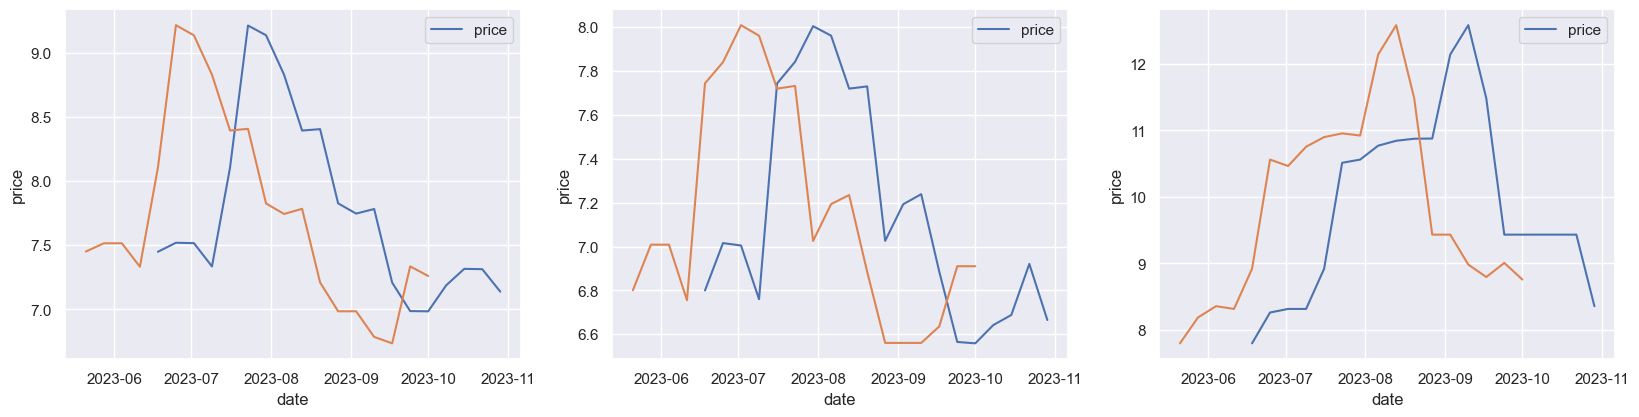

In [204]:
plt.subplot(231)
y_min = 6
y_max = 8.5
sns.lineplot(red_outcome);
sns.lineplot(df_red[-20:]["price"]);
ax.vlines(x=["2023-07-16","2023-08-13","2023-09-10","2023-10-01"],ymax=y_max,ymin=y_min)

plt.subplot(232)
y_min = 6
y_max = 8.5
sns.lineplot(green_outcome);
sns.lineplot(df_green[-20:]["price"]);
ax.vlines(x=["2023-07-16","2023-08-13","2023-09-10","2023-10-01"],ymax=y_max,ymin=y_min)

plt.subplot(233)
y_min = 6
y_max = 8.5
sns.lineplot(yellow_outcome);
sns.lineplot(df_yellow[-20:]["price"]);
ax.vlines(x=["2023-07-16","2023-08-13","2023-09-10","2023-10-01"],ymax=y_max,ymin=y_min)

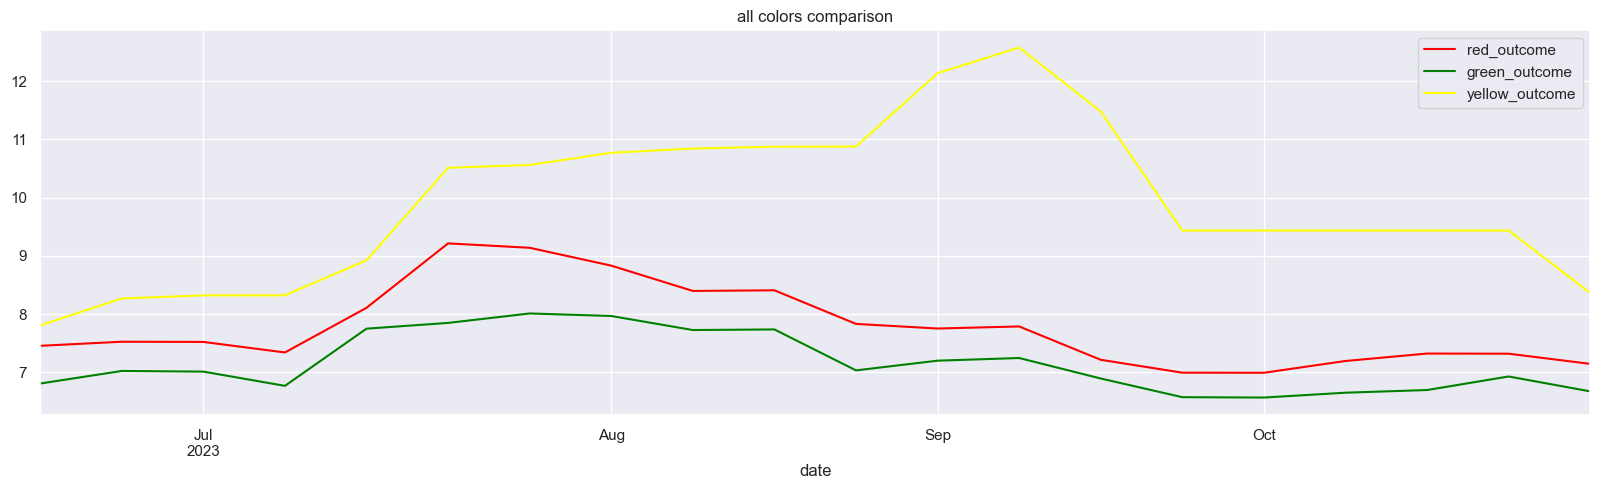

In [205]:
pd.concat([red_outcome,pd.concat([green_outcome,yellow_outcome],axis=1)],axis=1).plot(color=["red","green","yellow"],
                                                                                      figsize=(20,5),title="all colors comparison")
plt.legend(["red_outcome","green_outcome","yellow_outcome"]);

---